# Abstractive Summarization

Loading pre-trained GloVe embeddings.
Source of Data: https://nlp.stanford.edu/projects/glove/

Another interesting embedding to look into:
https://github.com/commonsense/conceptnet-numberbatch

In [10]:
import numpy as np
from __future__ import division
import nltk

In [11]:
filename = 'data/glove.6B.50d.txt'
def loadGloVe(filename):
    vocab = []
    embd = []
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd
vocab,embd = loadGloVe(filename)

embedding = np.asarray(embd)
embedding = embedding.astype(np.float32)

word_vec_dim = len(embedding[0])
#Pre-trained GloVe embedding

Loaded GloVe!


Here I will define functions for converting words to its vector representations and vice versa. 

### word2vec: 

Converts words to its vector representations.
If the word is not present in the vocabulary, and thus if it doesn't have any vector representation,
the word will be considered as 'unk' (denotes unknown) and the vector representation of unk will be
returned instead. 

### np_nearest_neighbour:

Returns the word vector in the vocabularity that is most similar
to word vector given as an argument. The similarity is evaluated based on the formula of cosine
similarity. 

### vec2word: 

Converts vectors to words. If the vector representation is unknown, and no corresponding word
is known, then it returns the word representation of a known vector representation which is most similar 
to the vector given as argument (the np_nearest_neighbour() function is used for that).


In [12]:
def np_nearest_neighbour(x):
    #returns array in embedding that's most similar (in terms of cosine similarity) to x
        
    xdoty = np.multiply(embedding,x)
    xdoty = np.sum(xdoty,1)
    xlen = np.square(x)
    xlen = np.sum(xlen,0)
    xlen = np.sqrt(xlen)
    ylen = np.square(embedding)
    ylen = np.sum(ylen,1)
    ylen = np.sqrt(ylen)
    xlenylen = np.multiply(xlen,ylen)
    cosine_similarities = np.divide(xdoty,xlenylen)

    return embedding[np.argmax(cosine_similarities)]


def word2vec(word):  # converts a given word into its vector representation
    if word in vocab:
        return embedding[vocab.index(word)]
    else:
        return embedding[vocab.index('unk')]

def vec2word(vec):   # converts a given vector representation into the represented word 
    for x in range(0, len(embedding)):
        if np.array_equal(embedding[x],np.asarray(vec)):
            return vocab[x]
    return vec2word(np_nearest_neighbour(np.asarray(vec)))

### Loading pre-processed dataset

The Data is preprocessed in [Data_Pre-processing.ipynb]



In [4]:
import pickle

with open ('vec_summaries', 'rb') as fp:
    vec_summaries = pickle.load(fp)

with open ('vec_texts', 'rb') as fp:
    vec_texts = pickle.load(fp)
    

FileNotFoundError: [Errno 2] No such file or directory: 'vec_summaries'

Here, I am Loading vocab_limit and embd_limit (though I may not ever use embd_limit).
Vocab_limit contains only vocabularies that are present in the dataset and 
some special words representing markers 'eos', '<PAD>' etc.

The network should output the probability distribution over the words in 
vocab_limit. So using limited vocabulary (vocab_limit) will mean requiring
less parameters for calculating the probability distribution.

In [4]:
with open ('vocab_limit', 'rb') as fp:
    vocab_limit = pickle.load(fp)

with open ('embd_limit', 'rb') as fp:
    embd_limit = pickle.load(fp)
    

Including SOS and its vector to the vocbularies. I forgot to do this while pre-processing.
SOS signifies start of the decoder token input. 

In [5]:
vocab_limit.append('<SOS>')
embd_limit.append(np.zeros((word_vec_dim),dtype=np.float32))

SOS = embd_limit[vocab_limit.index('<SOS>')]

np_embd_limit = np.asarray(embd_limit,dtype=np.float32)


### REMOVING DATA WITH SUMMARIES WHICH ARE TOO LONG

I will not be training the model in batches. I will train the model one sample at a time, because my laptop
will probably not be able to handle batch training (the kernel crashes now and then even with SGD ).

However, if I was training in batches I had to choose a fixed maximum length for output.
Each target output is marked with the word 'eos' at the end. After that each target output can be padded with
'<PAD>' to fit the maximum output length. The network can be taught to produce an output in the form
"word1 word2 eos <PAD> <PAD>". The batch training can be handled better if all target outputs are transformed
to a fixed length. 

But, the fixed length should be less than or equal to the length of the longest target output so as to
not discard any word from any target-output sample.

But there may be a few very long target outputs\summaries (say, 50+) whereas most summaries are near about
length 10. So to fix the length, lots of padding has to be done to most of the summaries just because there
are a few long summaries. 

Better to just remove the data whose summaries are bigger than a specified threshold (MAX_SUMMARY_LEN).
In this cell I will diagnose how many percentage of data will be removed for a given threshold length,
and in the next cell I will remove them.

Note: I am comparing len(summary_vec)-1, instead of len(summary_vec). The reason is that I am ignoring 
the last word vector which is the representation of the 'eos' marker. I will explain why later on this
notebook. 

### REMOVING DATA WITH TEXTS WHOSE LENGTH IS SMALLER THAN THE WINDOW SIZE

In this model I will try to implement <b>local attention</b> with standard encoder-decoder architecture.

Where global attention looks at all the hidden states of the encoder to determine where to attend to,
local attention looks only at the hidden states under the range pt-D to pt+D where D is empirically selected
and pt is a position determined by the program.
The range of pt-D to pt+D can be said to be the window where attention takes place.  Pt is the center of the
window.

I am treating D as a hyperparameter. The window size will be (pt-D)-(pt+D)+1 = 2D+1.

Now, obviously, the window needs to be smaller than or equal to the no. of the encoded hidden states themselves.
We will encode one hidden state for each words in the input text, so size of the hidden states will be equivalent
to the size of the input text.

So we must choose D such that 2D+1 is not bigger than the length of any text in the dataset.

To ensure that, I will first diagnose how many data will be removed for a given D, and in the next cell,
I will remove all input texts whose length is less than 2D+1.

### REMOVING DATA WITH TEXTS(REVIEWS) WHICH ARE TOO LONG

The RNN encoders will encode one word at a time. No. of words in the text data or in other words,
the length of the text size will also be the no. of timesteps for the encoder RNN. To make the training less intensive 
(so that it doesn't burden my laptop too much), I will be removing
all data with whose review size exceeds a given threshold (MAX_TEXT_LEN).


In [6]:
#DIAGNOSIS

count = 0

LEN = 7

for summary in vec_summaries:
    if len(summary)-1>LEN:
        count = count + 1
print("Percentage of dataset with summary length beyond "+str(LEN)+": "+str((count/len(vec_summaries))*100)+"% ")

count = 0

D = 10 

window_size = 2*D+1

for text in vec_texts:
    if len(text)<window_size+1:
        count = count + 1
print("Percentage of dataset with text length less that window size: "+str((count/len(vec_texts))*100)+"% ")

count = 0

LEN = 80

for text in vec_texts:
    if len(text)>LEN:
        count = count + 1
print("Percentage of dataset with text length more than "+str(LEN)+": "+str((count/len(vec_texts))*100)+"% ")

Percentage of dataset with summary length beyond 7: 16.146% 
Percentage of dataset with text length less that window size: 2.258% 
Percentage of dataset with text length more than 80: 40.412% 


Here I will start the aformentioned removal process.
vec_summary_reduced and vec_texts_reduced will contain the remaining data after the removal.

<b>Note: an important hyperparameter D is initialized here.</b>

D determines the window size of local attention as mentioned before.

In [7]:
MAX_SUMMARY_LEN = 7
MAX_TEXT_LEN = 80

#D is a major hyperparameters. Windows size for local attention will be 2*D+1
D = 10

window_size = 2*D+1

#REMOVE DATA WHOSE SUMMARIES ARE TOO BIG
#OR WHOSE TEXT LENGTH IS TOO BIG
#OR WHOSE TEXT LENGTH IS SMALLED THAN WINDOW SIZE

vec_summaries_reduced = []
vec_texts_reduced = []

i = 0
for summary in vec_summaries:
    if len(summary)-1<=MAX_SUMMARY_LEN and len(vec_texts[i])>=window_size and len(vec_texts[i])<=MAX_TEXT_LEN:
        vec_summaries_reduced.append(summary)
        vec_texts_reduced.append(vec_texts[i])
    i=i+1

Here I will start the aformentioned removal process.
vec_summary_reduced and vec_texts_reduced will contain the remaining data after the removal.

<b>Note: an important hyperparameter D is initialized here.</b>

D determines the window size of local attention as mentioned before.

In [8]:
train_len = int((.7)*len(vec_summaries_reduced))

train_texts = vec_texts_reduced[0:train_len]
train_summaries = vec_summaries_reduced[0:train_len]

val_len = int((.15)*len(vec_summaries_reduced))

val_texts = vec_texts_reduced[train_len:train_len+val_len]
val_summaries = vec_summaries_reduced[train_len:train_len+val_len]

test_texts = vec_texts_reduced[train_len+val_len:len(vec_summaries_reduced)]
test_summaries = vec_summaries_reduced[train_len+val_len:len(vec_summaries_reduced)]

In [9]:
print(train_len)

18293


The function transform_out() will convert the target output sample so that 
it can be in a format which can be used by tensorflow's 
sparse_softmax_cross_entropy_with_logits() for loss calculation.

Think of one hot encoding. This transformation is kind of like that.
All the words in the vocab_limit are like classes in this context.

However, instead of being precisely one hot encoded the output will be transformed
such that it will contain the list of indexes which would have been 'one' if it was one hot encoded.

In [10]:
def transform_out(output_text):
    output_len = len(output_text)
    transformed_output = np.zeros([output_len],dtype=np.int32)
    for i in range(0,output_len):
        transformed_output[i] = vocab_limit.index(vec2word(output_text[i]))
    return transformed_output   

### Hyperparameters

Here I am simply setting up some of the rest of the hyperparameters.
K, here, is a special hyperparameter. It denotes the no. of previous hidden states
to consider for residual connections. More on that later. 

In [11]:
#Some MORE hyperparameters and other stuffs

hidden_size = 500
learning_rate = 0.003
K = 5
vocab_len = len(vocab_limit)
training_iters = 5 

Setting up tensorflow placeholders.
The purpose of the placeholders are pretty much self explanatory from the name.

Note: tf_seq_len, and tf_output_len aren't really necessary. They can be derived 
from tf_text and tf_summary respectively, but I ended up making them anyway.

In [12]:
import tensorflow as tf

#placeholders
tf_text = tf.placeholder(tf.float32, [None,word_vec_dim])
tf_seq_len = tf.placeholder(tf.int32)
tf_summary = tf.placeholder(tf.int32,[None])
tf_output_len = tf.placeholder(tf.int32)

### FORWARD AND BACKWARD LSTM WITH RRA

I will be using the encoder-decoder architecture.
For the encoder I will be using a bi-directional LSTM.
Below is the function of the forward encoder (the LSTM in the forward direction
that starts from the first word and encodes a word in the context of previous words),
and then for the backward encoder (the LSTM in the backward direction
that starts from the last word and encodes a word in the context of later words)

The RNN used here, is a standard LSTM with RRA ([Residual Recurrent Attention](https://arxiv.org/abs/1709.03714))

Remember, the hyperparameter K?

The model will compute the weighted sum (weighted based on some trainable parameters
in the attention weight matrix) of the PREVIOUS K hidden states - the weighted sum
is denoted as RRA in this function.

hidden_residuals will contain the last K hidden states.

The RRA will influence the Hidden State calculation in LSTM.

(The attention weight matrix is to be normalized by dividing each elements by the sum of all 
the elements as said in the paper. But, here, I am normalizing it by softmax)

The purpose for this is to created connections between hidden states of different timesteps,
to establish long term dependencies.

In [13]:
def forward_encoder(inp,hidden,cell,
                    wf,uf,bf,
                    wi,ui,bi,
                    wo,uo,bo,
                    wc,uc,bc,
                    Wattention,seq_len,inp_dim):

    Wattention = tf.nn.softmax(Wattention,0)
    hidden_forward = tf.TensorArray(size=seq_len,dtype=tf.float32)
    
    hidden_residuals = tf.TensorArray(size=K,dynamic_size=True,dtype=tf.float32,clear_after_read=False)
    hidden_residuals = hidden_residuals.unstack(tf.zeros([K,hidden_size],dtype=tf.float32))
    
    i=0
    j=K
    
    def cond(i,j,hidden,cell,hidden_forward,hidden_residuals):
        return i < seq_len
    
    def body(i,j,hidden,cell,hidden_forward,hidden_residuals):
        
        x = tf.reshape(inp[i],[1,inp_dim])
        
        hidden_residuals_stack = hidden_residuals.stack()
        
        RRA = tf.reduce_sum(tf.multiply(hidden_residuals_stack[j-K:j],Wattention),0)
        RRA = tf.reshape(RRA,[1,hidden_size])
        
        # LSTM with RRA
        fg = tf.sigmoid( tf.matmul(x,wf) + tf.matmul(hidden,uf) + bf)
        ig = tf.sigmoid( tf.matmul(x,wi) + tf.matmul(hidden,ui) + bi)
        og = tf.sigmoid( tf.matmul(x,wo) + tf.matmul(hidden,uo) + bo)
        cell = tf.multiply(fg,cell) + tf.multiply(ig,tf.sigmoid( tf.matmul(x,wc) + tf.matmul(hidden,uc) + bc))
        hidden = tf.multiply(og,tf.tanh(cell+RRA))
        
        hidden_residuals = tf.cond(tf.equal(j,seq_len-1+K),
                                   lambda: hidden_residuals,
                                   lambda: hidden_residuals.write(j,tf.reshape(hidden,[hidden_size])))

        hidden_forward = hidden_forward.write(i,tf.reshape(hidden,[hidden_size]))
        
        return i+1,j+1,hidden,cell,hidden_forward,hidden_residuals
    
    _,_,_,_,hidden_forward,hidden_residuals = tf.while_loop(cond,body,[i,j,hidden,cell,hidden_forward,hidden_residuals])
    
    hidden_residuals.close().mark_used()
    
    return hidden_forward.stack()
        

In [14]:
def backward_encoder(inp,hidden,cell,
                     wf,uf,bf,
                     wi,ui,bi,
                     wo,uo,bo,
                     wc,uc,bc,
                     Wattention,seq_len,inp_dim):
    
    Wattention = tf.nn.softmax(Wattention,0)
    hidden_backward = tf.TensorArray(size=seq_len,dtype=tf.float32)
    
    hidden_residuals = tf.TensorArray(size=K,dynamic_size=True,dtype=tf.float32,clear_after_read=False)
    hidden_residuals = hidden_residuals.unstack(tf.zeros([K,hidden_size],dtype=tf.float32))
    
    i=seq_len-1
    j=K
    
    def cond(i,j,hidden,cell,hidden_backward,hidden_residuals):
        return i > -1
    
    def body(i,j,hidden,cell,hidden_backward,hidden_residuals):
        
        x = tf.reshape(inp[i],[1,inp_dim])
        
        hidden_residuals_stack = hidden_residuals.stack()
        
        RRA = tf.reduce_sum(tf.multiply(hidden_residuals_stack[j-K:j],Wattention),0)
        RRA = tf.reshape(RRA,[1,hidden_size])
        
        # LSTM with RRA
        fg = tf.sigmoid( tf.matmul(x,wf) + tf.matmul(hidden,uf) + bf)
        ig = tf.sigmoid( tf.matmul(x,wi) + tf.matmul(hidden,ui) + bi)
        og = tf.sigmoid( tf.matmul(x,wo) + tf.matmul(hidden,uo) + bo)
        cell = tf.multiply(fg,cell) + tf.multiply(ig,tf.sigmoid( tf.matmul(x,wc) + tf.matmul(hidden,uc) + bc))
        hidden = tf.multiply(og,tf.tanh(cell+RRA))

        hidden_residuals = tf.cond(tf.equal(j,seq_len-1+K),
                                   lambda: hidden_residuals,
                                   lambda: hidden_residuals.write(j,tf.reshape(hidden,[hidden_size])))
        
        hidden_backward = hidden_backward.write(i,tf.reshape(hidden,[hidden_size]))
        
        return i-1,j+1,hidden,cell,hidden_backward,hidden_residuals
    
    _,_,_,_,hidden_backward,hidden_residuals = tf.while_loop(cond,body,[i,j,hidden,cell,hidden_backward,hidden_residuals])

    hidden_residuals.close().mark_used()
    
    return hidden_backward.stack()
        

The decoder similarly uses LSTM with RRA

In [15]:
def decoder(x,hidden,cell,
            wf,uf,bf,
            wi,ui,bi,
            wo,uo,bo,
            wc,uc,bc,RRA):
    
    # LSTM with RRA
    fg = tf.sigmoid( tf.matmul(x,wf) + tf.matmul(hidden,uf) + bf)
    ig = tf.sigmoid( tf.matmul(x,wi) + tf.matmul(hidden,ui) + bi)
    og = tf.sigmoid( tf.matmul(x,wo) + tf.matmul(hidden,uo) + bo)
    cell_next = tf.multiply(fg,cell) + tf.multiply(ig,tf.sigmoid( tf.matmul(x,wc) + tf.matmul(hidden,uc) + bc))
    hidden_next = tf.multiply(og,tf.tanh(cell+RRA))
    
    return hidden_next,cell_next

### LOCAL ATTENTION:

The cell below includes some major functions for the attention mechanism.

The attention mechanism is usually implemented to compute an attention score 
for each of the encoded hidden state in the context of a particular
decoder hidden state in each timestep - all to determine which encoded hidden
states to attend to for a particular decoder hidden state context.

More specifically, I am here implementing local attention as opposed to global attention.

I already mentioned local attention before. Local attention mechanism involves focusing on
a subset of encoded hidden states, whereas a gloabl attention mechanism invovles focusing on all
the encoded hidden states.

This is the paper on which this implementation is based on:
https://nlp.stanford.edu/pubs/emnlp15_attn.pdf
    
Following the formulas presented in the paper, first, I am computing
the position pt (the center of the window of attention).

pt is simply a position in the sequence.
For a given pt, the model will only consider the hidden state starting from the position
pt-D to the hidden state at the position pt+D. 

To say a hidden state is at position p, I mean to say that the hidden state is the encoded
representation of a word at position p in the sequence.

The paper formulates the equation for calculating pt like this:
pt = sequence_length x sigmoid(..some linear algebras and activations...)

But, I didn't used the sequence_length of the whole text which is tf_seq_len but 'positions' which
is = tf_seq_len-1-2D

if pt = tf_seq_len x sigmoid(tensor)

Then pt will be in the range 0 to tf_seq_len

But, we can't have that. There is no tf_seq_len position. Since the length is tf_seq_len,
the available positions are 0 to (tf_seq_len-1). Which is why I subtracted 1 from it.

Next, we must have the value of pt to be such that it represents the CENTER of the window.
If pt is too close to 0, pt-D will be negative - a non-existent position.
If pt is too close to tf_seq_len, pt+D will be a non-existent position.

So pt can't occupy the first D positions (0 to D-1) and it can't occupy the last D positions
((tf_seq_len-D) to (tf_seq_len-1)) in order to keep pt-D and pt+D as legal positions.
So a total 2D positions should be restricted to pt.

Which is why I further subtracted 2D from tf_seq_len.

Still, after calculating pt = positions x sigmoid(tensor)
where positions = tf_seq_len-(2D+1), 
pt will merely range between 0 to tf_seq_len-(2D+1)

We can't still accept pt to be 0 since pt-D will be negative. But the length of the range 
of integer positions pt can occupy is now perfect.

So at this point, we can simply center pt at the window by adding a D.

After that, pt will range from D to (tf_seq_len-1)-D

Now, it can be checked that pt+D, or pt-D will never become negative or exceed
the total sequence length.

After calculating pt, we can use the formulas presented in the paper to calculate
the G score which signifies the weight (or attention) that should be given to a hidden state.

G scores is calculated for each of hidden states in the local window. This is equivalent to
a(s) used in the paper.

The function returns the G scores and the position pt, so that the model can create the 
context vector. 


In [16]:
def score(hs,ht,Wa,seq_len):
    return tf.reshape(tf.matmul(tf.matmul(hs,Wa),tf.transpose(ht)),[seq_len])

def align(hs,ht,Wp,Vp,Wa,tf_seq_len):
   
    pd = tf.TensorArray(size=(2*D+1),dtype=tf.float32)
    
    positions = tf.cast(tf_seq_len-1-2*D,dtype=tf.float32)
    
    sigmoid_multiplier = tf.nn.sigmoid(tf.matmul(tf.tanh(tf.matmul(ht,Wp)),Vp))
    sigmoid_multiplier = tf.reshape(sigmoid_multiplier,[])
    
    pt_float = positions*sigmoid_multiplier
    
    pt = tf.cast(pt_float,tf.int32)
    pt = pt+D #center to window
    
    sigma = tf.constant(D/2,dtype=tf.float32)
    
    i = 0
    pos = pt - D
    
    def cond(i,pos,pd):
        
        return i < (2*D+1)
                      
    def body(i,pos,pd):
        
        comp_1 = tf.cast(tf.square(pos-pt),tf.float32)
        comp_2 = tf.cast(2*tf.square(sigma),tf.float32)
            
        pd = pd.write(i,tf.exp(-(comp_1/comp_2)))
            
        return i+1,pos+1,pd
                      
    i,pos,pd = tf.while_loop(cond,body,[i,pos,pd])
    
    local_hs = hs[(pt-D):(pt+D+1)]
    
    normalized_scores = tf.nn.softmax(score(local_hs,ht,Wa,2*D+1))
    
    pd=pd.stack()
    
    G = tf.multiply(normalized_scores,pd)
    G = tf.reshape(G,[2*D+1,1])
    
    return G,pt


### MODEL DEFINITION

First is the <b>bi-directional encoder</b>.

h_forward is the tensorarray of all the hidden states from the 
forward encoder whereas h_backward is the tensorarray of all the hidden states
from the backward encoder.

The final list of encoder hidden states are usually calculated by combining 
the equivalents of h_forward and h_backward by some means.

There are many means of combining them, like: concatenation, summation, average etc.
    
I will be using concatenation.

hidden_encoder is the final list of encoded hidden state

The first decoder input is the word vector representation of <SOS> which siginfies the start of decoding.

I am using the first encoded_hidden_state 
as the initial decoder state. The first encoded_hidden_state may have the least 
past context (none actually) but, it will have the most future context.

The next decoder hidden state is generated from the initial decoder input and the initial decoder state.
Next, I start a loop which iterates for output_len times. 

Next the <b>attention function</b> is called, to compute the G score by scoring the encoder hidden states
in term of current decoder hidden step.

The context vector is created by the weighted (weighted in terms of G scores) summation
of hidden states in the local attention window.

I used the formulas mentioned here: https://nlp.stanford.edu/pubs/emnlp15_attn.pdf

to calculate the probability distribution for the first output token from the context vector and decoder hidden state.

The word vector represention of the output token - the word with maximum the predicted probability in the recently calculated probability distribution, is used as the decoder input token. The output decoder hidden state from that current decoder input token, and the hidden state, is used again in the next loop to calculate the probability distribution of the next output token and so on. 

('beam search' is another approach to look into at this part)

The loop continues for 'output_len' no. of iterations. 

Since I will be training sample to sample, I can dynamically send the output length 
of the current sample, and the decoder loops for the given 'output length' times.

NOTE: I am saving only the (non-softmaxed) probability distributions for prediction. 

In [17]:
def model(tf_text,tf_seq_len,tf_output_len):
    
    #PARAMETERS
    
    #1.1 FORWARD ENCODER PARAMETERS
    
    initial_hidden_f = tf.zeros([1,hidden_size],dtype=tf.float32)
    cell_f = tf.zeros([1,hidden_size],dtype=tf.float32)
    wf_f = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    uf_f = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bf_f = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    wi_f = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    ui_f = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bi_f = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    wo_f = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    uo_f = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bo_f = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    wc_f = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    uc_f = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bc_f = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    Wattention_f = tf.Variable(tf.zeros([K,1]),dtype=tf.float32)
                               
    #1.2 BACKWARD ENCODER PARAMETERS
    
    initial_hidden_b = tf.zeros([1,hidden_size],dtype=tf.float32)
    cell_b = tf.zeros([1,hidden_size],dtype=tf.float32)
    wf_b = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    uf_b = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bf_b = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    wi_b = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    ui_b = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bi_b = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    wo_b = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    uo_b = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bo_b = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    wc_b = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,hidden_size],stddev=0.01))
    uc_b = tf.Variable(np.eye(hidden_size),dtype=tf.float32)
    bc_b = tf.Variable(tf.zeros([1,hidden_size]),dtype=tf.float32)
    Wattention_b = tf.Variable(tf.zeros([K,1]),dtype=tf.float32)
    
    #2 ATTENTION PARAMETERS
    
    Wp = tf.Variable(tf.truncated_normal(shape=[2*hidden_size,50],stddev=0.01))
    Vp = tf.Variable(tf.truncated_normal(shape=[50,1],stddev=0.01))
    Wa = tf.Variable(tf.truncated_normal(shape=[2*hidden_size,2*hidden_size],stddev=0.01))
    Wc = tf.Variable(tf.truncated_normal(shape=[4*hidden_size,2*hidden_size],stddev=0.01))
    
    #3 DECODER PARAMETERS
    
    Ws = tf.Variable(tf.truncated_normal(shape=[2*hidden_size,vocab_len],stddev=0.01))
    
    cell_d = tf.zeros([1,2*hidden_size],dtype=tf.float32)
    wf_d = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,2*hidden_size],stddev=0.01))
    uf_d = tf.Variable(np.eye(2*hidden_size),dtype=tf.float32)
    bf_d = tf.Variable(tf.zeros([1,2*hidden_size]),dtype=tf.float32)
    wi_d = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,2*hidden_size],stddev=0.01))
    ui_d = tf.Variable(np.eye(2*hidden_size),dtype=tf.float32)
    bi_d = tf.Variable(tf.zeros([1,2*hidden_size]),dtype=tf.float32)
    wo_d = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,2*hidden_size],stddev=0.01))
    uo_d = tf.Variable(np.eye(2*hidden_size),dtype=tf.float32)
    bo_d = tf.Variable(tf.zeros([1,2*hidden_size]),dtype=tf.float32)
    wc_d = tf.Variable(tf.truncated_normal(shape=[word_vec_dim,2*hidden_size],stddev=0.01))
    uc_d = tf.Variable(np.eye(2*hidden_size),dtype=tf.float32)
    bc_d = tf.Variable(tf.zeros([1,2*hidden_size]),dtype=tf.float32)
    
    hidden_residuals_d = tf.TensorArray(size=K,dynamic_size=True,dtype=tf.float32,clear_after_read=False)
    hidden_residuals_d = hidden_residuals_d.unstack(tf.zeros([K,2*hidden_size],dtype=tf.float32))
    
    Wattention_d = tf.Variable(tf.zeros([K,1]),dtype=tf.float32)
    
    output = tf.TensorArray(size=tf_output_len,dtype=tf.float32)
                               
    #BI-DIRECTIONAL LSTM
                               
    hidden_forward = forward_encoder(tf_text,
                                     initial_hidden_f,cell_f,
                                     wf_f,uf_f,bf_f,
                                     wi_f,ui_f,bi_f,
                                     wo_f,uo_f,bo_f,
                                     wc_f,uc_f,bc_f,
                                     Wattention_f,
                                     tf_seq_len,
                                     word_vec_dim)
    
    hidden_backward = backward_encoder(tf_text,
                                     initial_hidden_b,cell_b,
                                     wf_b,uf_b,bf_b,
                                     wi_b,ui_b,bi_b,
                                     wo_b,uo_b,bo_b,
                                     wc_b,uc_b,bc_b,
                                     Wattention_b,
                                     tf_seq_len,
                                     word_vec_dim)
    
    encoded_hidden = tf.concat([hidden_forward,hidden_backward],1)
    
    #ATTENTION MECHANISM AND DECODER
    
    decoded_hidden = encoded_hidden[0]
    decoded_hidden = tf.reshape(decoded_hidden,[1,2*hidden_size])
    Wattention_d_normalized = tf.nn.softmax(Wattention_d)
    tf_embd_limit = tf.convert_to_tensor(np_embd_limit)
    
    y = tf.convert_to_tensor(SOS) #inital decoder token <SOS> vector
    y = tf.reshape(y,[1,word_vec_dim])
    
    j=K
    
    hidden_residuals_stack = hidden_residuals_d.stack()
    
    RRA = tf.reduce_sum(tf.multiply(hidden_residuals_stack[j-K:j],Wattention_d_normalized),0)
    RRA = tf.reshape(RRA,[1,2*hidden_size])
    
    decoded_hidden_next,cell_d = decoder(y,decoded_hidden,cell_d,
                                  wf_d,uf_d,bf_d,
                                  wi_d,ui_d,bf_d,
                                  wo_d,uo_d,bf_d,
                                  wc_d,uc_d,bc_d,
                                  RRA)
    decoded_hidden = decoded_hidden_next
    
    hidden_residuals_d = hidden_residuals_d.write(j,tf.reshape(decoded_hidden,[2*hidden_size]))
    
    j=j+1
                           
    i=0
    
    def attention_decoder_cond(i,j,decoded_hidden,cell_d,hidden_residuals_d,output):
        return i < tf_output_len
    
    def attention_decoder_body(i,j,decoded_hidden,cell_d,hidden_residuals_d,output):
        
        #LOCAL ATTENTION
        
        G,pt = align(encoded_hidden,decoded_hidden,Wp,Vp,Wa,tf_seq_len)
        local_encoded_hidden = encoded_hidden[pt-D:pt+D+1]
        weighted_encoded_hidden = tf.multiply(local_encoded_hidden,G)
        context_vector = tf.reduce_sum(weighted_encoded_hidden,0)
        context_vector = tf.reshape(context_vector,[1,2*hidden_size])
        
        attended_hidden = tf.tanh(tf.matmul(tf.concat([context_vector,decoded_hidden],1),Wc))
        
        #DECODER
        
        y = tf.matmul(attended_hidden,Ws)
        
        output = output.write(i,tf.reshape(y,[vocab_len]))
        #Save probability distribution as output
        
        y = tf.nn.softmax(y)
        
        y_index = tf.cast(tf.argmax(tf.reshape(y,[vocab_len])),tf.int32)
        y = tf_embd_limit[y_index]
        y = tf.reshape(y,[1,word_vec_dim])
        
        #setting next decoder input token as the word_vector of maximum probability 
        #as found from previous attention-decoder output.
        
        hidden_residuals_stack = hidden_residuals_d.stack()
        
        RRA = tf.reduce_sum(tf.multiply(hidden_residuals_stack[j-K:j],Wattention_d_normalized),0)
        RRA = tf.reshape(RRA,[1,2*hidden_size])
        
        decoded_hidden_next,cell_d = decoder(y,decoded_hidden,cell_d,
                                  wf_d,uf_d,bf_d,
                                  wi_d,ui_d,bf_d,
                                  wo_d,uo_d,bf_d,
                                  wc_d,uc_d,bc_d,
                                  RRA)
        
        decoded_hidden = decoded_hidden_next
        
        hidden_residuals_d = tf.cond(tf.equal(j,tf_output_len-1+K+1), #(+1 for <SOS>)
                                   lambda: hidden_residuals_d,
                                   lambda: hidden_residuals_d.write(j,tf.reshape(decoded_hidden,[2*hidden_size])))
        
        return i+1,j+1,decoded_hidden,cell_d,hidden_residuals_d,output
    
    i,j,decoded_hidden,cell_d,hidden_residuals_d,output = tf.while_loop(attention_decoder_cond,
                                            attention_decoder_body,
                                            [i,j,decoded_hidden,cell_d,hidden_residuals_d,output])
    hidden_residuals_d.close().mark_used()
    
    output = output.stack()
    
    return output

The model function is initiated here. The output is
computed. Cost function and optimizer are defined.
I am creating a prediction tensorarray which will 
store the index of maximum element of 
the output probability distributions.
From that index I can find the word in vocab_limit
which is represented by it. So the final visible
predictions will be the words that the model decides to
be most probable.

In [ ]:
output = model(tf_text,tf_seq_len,tf_output_len)

#OPTIMIZER

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=tf_summary))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#PREDICTION

pred = tf.TensorArray(size=tf_output_len,dtype=tf.int32)

i=0

def cond_pred(i,pred):
    return i<tf_output_len
def body_pred(i,pred):
    pred = pred.write(i,tf.cast(tf.argmax(output[i]),tf.int32))
    return i+1,pred

i,pred = tf.while_loop(cond_pred,body_pred,[i,pred]) 

prediction = pred.stack()

### TRAINING

Finally, this is where training takes place.
It's all pretty self explanatory, but one thing to note is that
I am sending "train_summaries[i][0:len(train_summaries[i])-1]"
to the transform_out() function. That is, I am ignoring the last
word from summary. The last word marks the end of the summary.
It's 'eos'. 

I trained it before without dynamically feeding the output_len.
Ideally the network should determine the output_len by itself.

Which is why I defined (in past) a MAX_LEN, and transformed target outputs in
the form "word1 word2 word3....eos <PAD> <PAD>....until max_length"
I created the model output in the same way.

The model would ideally learn in which context and where to put eos.
And then the only the portion before eos can be shown to the user.

After training, the model can even be modified to run until,
the previous output y denotes an eos. 

That way, we can have variable length output, with the length decided
by the model itself, not the user.

But all the padding and eos, makes the model to come in contact with 
pads and eos in most of the target output. The model learns to consider eos and 
pad to be important. Trying to fit to the data, the early model starts to
spam eos and pad in its predicted output.

That necessarily isn't a problem. The model may learn to fare better
later on, but I planned only to check a couple of early iterations, 
and looking at predictions consisting of only eos and pads
isn't too interesting. I wanted to check what kind of words (other than
eos and pads) the model learns to produce in the early iterations. 

Which is why I am doing what I am doing. Ideally, my past implemention
waould be better. 

As I said before, I will run it for only a few early iterations.
So, it's not likely to see any great predicted summaries here.
As can be seen, the summaries seem more influenced by previous 
output sample than the input context in these early iterations.

Some of the texts contains undesirable words like br tags and so
on. So better preprocessing and tokenization may be desirable.

With more layer depth, larger hidden size, mini-batch training,
and other changes, this model may have potential, or may not.

The same arcitechture should be usable for training on translation data.


In [ ]:
import string
from __future__ import print_function

init = tf.global_variables_initializer()
#Variables for Bleu Calculation



with tf.Session() as sess: # Start Tensorflow Session
    
    saver = tf.train.Saver() 
    # Prepares variable for saving the model
    sess.run(init) #initialize all variables
    step = 0   
    loss_list=[]
    acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    best_val_acc=0
    display_step = 1
    
    while step < training_iters:
        
        total_loss=0
        total_acc=0
        total_val_loss = 0
        total_val_acc = 0
           
        for i in range(0,train_len):
            
            train_out = transform_out(train_summaries[i][0:len(train_summaries[i])-1])
            
            if i%display_step==0:
                print("\nIteration: "+str(i))
                print("Training input sequence length: "+str(len(train_texts[i])))
                print("Training target outputs sequence length: "+str(len(train_out)))
            
                print("\nTEXT:")
                flag = 0
                for vec in train_texts[i]:
                    if vec2word(vec) in string.punctuation or flag==0:
                        print(str(vec2word(vec)),end='')
                    else:
                        print((" "+str(vec2word(vec))),end='')
                    flag=1

                print("\n")


            # Run optimization operation (backpropagation)
            _,loss,pred = sess.run([optimizer,cost,prediction],feed_dict={tf_text: train_texts[i], 
                                                    tf_seq_len: len(train_texts[i]), 
                                                    tf_summary: train_out,
                                                    tf_output_len: len(train_out)})
            
         
            if i%display_step==0:
                print("\nPREDICTED SUMMARY:\n")
                flag = 0
                for index in pred:
                    #if int(index)!=vocab_limit.index('eos'):
                    if vocab_limit[int(index)] in string.punctuation or flag==0:
                        summary_ = str(vocab_limit[int(index)])
                        print(" "+ summary_,end='')
                        pred_summaries_.append( nltk.word_tokenize(summary_))
                    else:
                        summary_ = str(vocab_limit[int(index)])
                        print(" "+ summary_,end='')
                        pred_summaries_.append( nltk.word_tokenize(summary_))                       
                        
                    flag=1
                print("\n")
                
                print("ACTUAL SUMMARY:\n")
                flag = 0
                for vec in train_summaries[i]:
                    if vec2word(vec)!='eos':
                        if vec2word(vec) in string.punctuation or flag==0:
                            summary_ = str(vec2word(vec))
                            print(" "+ summary_,end='')
                            actual_summaries_.append( nltk.word_tokenize(summary_)) 
                        
                        else:
                            summary_ = (" "+str(vec2word(vec)))
                            print(" "+ summary_,end='')
                            actual_summaries_.append( nltk.word_tokenize(summary_)) 
                    flag=1

                print("\n")
                print("loss="+str(loss))
            
        step=step+1
    


Iteration: 0
Training input sequence length: 51
Training target outputs sequence length: 4

TEXT:
i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than most.


PREDICTED SUMMARY:

pricey pricey substantive substantive

ACTUAL SUMMARY:

good quality dog food

loss=10.4001

Iteration: 1
Training input sequence length: 37
Training target outputs sequence length: 3

TEXT:
product arrived labeled as jumbo salted peanuts ... the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as `` jumbo ''.


PREDICTED SUMMARY:

dog dog food

ACTUAL SUMMARY:

not as advertised

loss=10.4679

Iteration: 2
Training input sequence length: 46
Training target outputs sequence length: 2

TEXT:
if you are looking for the secret ingredient

### To Try\ To Do\ To keep in mind:

* Beam Search
* Pointer Mechanisms
* Heirarchical attention
* [Intra-input-attention](https://arxiv.org/pdf/1705.04304.pdf)
* Better pre-processing
* Switch to PyTorch for dynamic models.
* Mini-Batch Training
* Better Datasets.
* Train for different tasks (eg. Translation) using different datasets.
* Intra-layer attention for both encoder and decoder together with everything else.
* Adopt a more object oriented approach

In [5]:
import nltk

list_of_references = [actual_summaries_] # list of references for all sentences in corpus.
list_of_hypotheses = [pred_summaries_] # list of hypotheses that corresponds to list of references.


corpus_bleu = nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)
print('Overall Bleu is: ',corpus_bleu)

//anaconda/lib/python3.5/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6025286104785453

//anaconda/lib/python3.5/site-packages/nltk/translate/bleu_score.py:472: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


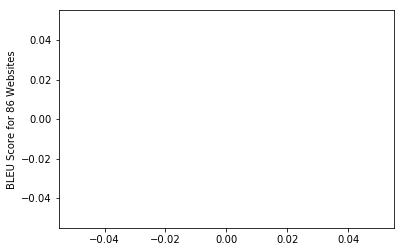

In [9]:
def bleu(list_of_references, list_of_hypotheses):
    nltk.translate.bleu_score.sentence_bleu(list_of_references, list_of_hypotheses)

scores = []
for i in range(len(list_of_references)):
    scores.append(bleu([list_of_references[i]],[list_of_hypotheses[i]]))
    
import matplotlib.pyplot as plt
plt.plot(scores)
plt.ylabel('BLEU Score for each site')
plt.show()